<a href="https://colab.research.google.com/github/varinen/handson-unsupervised-learning/blob/master/Chap12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks

## GANs, the Concept

GANs were introduced by Ian Goodfellow and colleagues at the University of Montreal in 2014. In the core of the idea are two neural networks. One is known as the *generator*. It produces data based on the original samples provided as an input. The other network known as the *discriminator* tries to guess which of the supplied data samples belong to the original distribution and which have been generated. The two networks are locked in a zero-sum game, one network trying to fool the discriminator and the other trying to call out the data generated by the generator as fake.

GANs is an unsupervised approach. The generator is capable of learning the original distribution without any labels. The learning is done by using fewer parameters than the input data has. This forces the generator to learn the most salient properties of the input. Each subsequent layer in the generator learns a representation of the data coming from the preceding layer and in each step more complex and abstract properties are discovered and learned. 

The discriminator forces the generator to learn a representation that will allow generating of data almost identical to the original.

## The Power of GANs

In the previous chapters, we have already use DBN to generate additional training data for a supervised algorithm. GANs are particularly effective in generating synthetic data that appears real. So,  in order to efficiently train a supervised image recognition  algorithm, we need a lot of training data. We can take an available smaller dataset, run it through a GAN and then use the generator to produce as much training data as we need.

GANs can be powerful in anomaly  detection. We can set up a GAN so that the fakes caught by the discriminator as "likely synthetic data" are considered  anomalies. This can be applied to, for example, credit fraud card detection.

## Deep Convolutional GANs

In this  chapter, we will use the MNIST dataset to generate synthetic data using GANs. We then will apply a supervised learning model to perform image classification.

This version of GAN is called a *deep convolutional generative adversarial  network (DCGAN)*, DCGANs have been first introduced in late 2015 by Alec Radform, Luke Metz, and Soumith Chinala.

## Convolutional Neural Networks

Compared to text and numerical data, images and video are computationally much more intensive. A single 4k Ultra HD video frame has dimensions of $4096 \times 2160 \times 3$ (26_452_080). Training a network on an image like thin in full resolution will require a network of millions of neurons and will take a lot of time.

Instead of building a network for raw images, we can use images reduced in dimensions. The idea behind such a reduction is that pixels in an image relate to pixels nearest to them and not to pixels elsewhere.

*Convolution* is a process that filters the image to decrease the size of an image without losing the relationships between pixels.

The convolution process applies a  filter  to a small image area known as *kernel size* and moving this area with a small step (*stride*). In the end, the max pixel is taken from each of the areas to build a much smaller version of an image. This last step is known as *max pooling*.

Let's build a CNN and use it to perform image classification on the MNIST dataset. First, we need to input the required libraries:

In [2]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import Grid

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error
from keras.utils import to_categorical

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import LeakyReLU, Reshape, UpSampling2D, Conv2DTranspose
from keras.layers import BatchNormalization, Input, Lambda
from keras.layers import Embedding, Flatten, dot
from keras import regularizers
from keras.losses import mse, binary_crossentropy
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adam, RMSprop
from tensorflow.examples.tutorials.mnist import input_data


Using TensorFlow backend.


Next, we will load the MNIST data and store it in a 4D tensor that Keras needs to work with. We will take labels and convert them to one-hot-vectors using the `to_categorical` function in Keras.
For later use, we will store the dataset in Pandas DataFrames. We will also reuse the `show_digit` function from previous chapters.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
current_path = 'gdrive/My Drive/Colab Notebooks/datasets/mnist/'
file  = 'mnist.pkl.gz'

f = gzip.open(current_path+file, 'rb')
train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
f.close()

X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

In [0]:
X_train_keras = X_train.reshape(50000,28,28,1)
X_validation_keras = X_validation.reshape(10000,28,28,1)
X_test_keras = X_test.reshape(10000,28,28,1)

y_train_keras = to_categorical(y_train)
y_validation_keras = to_categorical(y_validation)
y_test_keras = to_categorical(y_test)

In [0]:
# Create Pandas DataFrames from the datasets
train_index = range(0,len(X_train))
validation_index = range(len(X_train),len(X_train)+len(X_validation))
test_index = range(len(X_train)+len(X_validation),len(X_train)+ \
                   len(X_validation)+len(X_test))

X_train = pd.DataFrame(data=X_train,index=train_index)
y_train = pd.Series(data=y_train,index=train_index)

X_validation = pd.DataFrame(data=X_validation,index=validation_index)
y_validation = pd.Series(data=y_validation,index=validation_index)

X_test = pd.DataFrame(data=X_test,index=test_index)
y_test = pd.Series(data=y_test,index=test_index)

In [0]:
def view_digit(X, y, example):
    label = y.loc[example]
    image = X.loc[example,:].values.reshape([28,28])
    plt.title('Example: %d  Label: %d' % (example, label))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

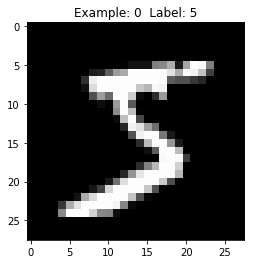

In [8]:
# View the first digit
view_digit(X_train, y_train, 0)

In order to use the GPU, we need to change the Colab Runtime Type to "Hardware Accelerator: GPU".

In [9]:
# Confirm use of GPU
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else: print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


### GAN Design

We start building the GAN by calling `sequential()` in Keras. We will add two convolutional layers, each with 32 filters and a kernel size of 5 by 5, a default stride of 1, and ReLU activation.

We will also perform dropout to safeguard against overfitting. The dropout will be 25%.

In the next stage, we will add two more convolutional layers, each with 64 filters and a kernel size of 3 by 3. We will also do a max pooling with a window of 2 by 2 and a stride of 2. We will add a dropout layer with a dropout value of 25% of the input units.

Finally, we will flatten the images, add a regular neural network with 256 hidden units, perform dropout of 50% and perform a 10-class classification using the softmax function.

In [0]:
model = Sequential()

# First stage
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.25))


# Second stage
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', 
                 activation ='relu'))

model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

# Flatten images and feed to a dense layer:
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))


To train this CNN we will use the *Adam optimizer* and minimize cross-entropy. We will also store the image classification accuracy as the evaluation metric.

Let's train the model for 100 epochs and evaluate the results on the validation set:

In [0]:
# Train CNN
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [0]:
cnn_history = model.fit(X_train_keras, y_train_keras, 
          validation_data=(X_validation_keras, y_validation_keras), \
          epochs=100)

W0708 15:21:29.757631 140216533751680 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 30s 593us/step - loss: 0.1930 - acc: 0.9394 - val_loss: 0.0422 - val_acc: 0.9879
Epoch 2/100
50000/50000 [==============================] - 24s 473us/step - loss: 0.0709 - acc: 0.9789 - val_loss: 0.0337 - val_acc: 0.9897
Epoch 3/100
50000/50000 [==============================] - 23s 470us/step - loss: 0.0545 - acc: 0.9838 - val_loss: 0.0318 - val_acc: 0.9915
Epoch 4/100
50000/50000 [==============================] - 23s 469us/step - loss: 0.0440 - acc: 0.9870 - val_loss: 0.0315 - val_acc: 0.9913
Epoch 5/100
50000/50000 [==============================] - 23s 466us/step - loss: 0.0401 - acc: 0.9877 - val_loss: 0.0257 - val_acc: 0.9928
Epoch 6/100
50000/50000 [==============================] - 23s 469us/step - loss: 0.0364 - acc: 0.9893 - val_loss: 0.0272 - val_acc: 0.9924
Epoch 7/100
50000/50000 [==============================] - 23s 468us/step - loss: 0.0323 - acc: 0.9904 - val_l

In [0]:
print(cnn_history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


CNN Final Accuracy 0.99558


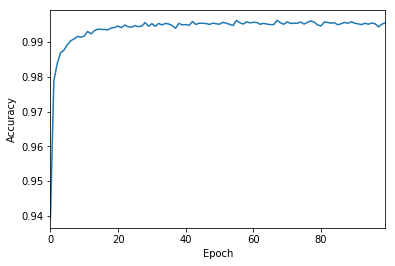

In [0]:
# Plot Accuracy of CNN
print("CNN Final Accuracy", cnn_history.history['acc'][-1])
pd.Series(cnn_history.history['acc']).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

As you can see,  the trained CNN has an accuracy of 99.56%, better than any other MNIST image classification methods we trained before.

## DCGANs Revisited

Now, we will return to deep convolutional generative adversarial networks. We will build a generative model to generate synthetic MNIST data that are very similar to the MNIST dataset.

To produce near-realistic images, we will have to train a generator that generates new images from the original MNIST images and a discriminator to judge where those images are believably similar to the original ones or not.

For the generator we will use the architecture proposed by Radford, Metz, and Chintala paper presented at the ICLR 2016 conference.

![alt text](https://www.divisionlab.com/solvingmagento/wp-content/uploads/2019/DCGAN.png)

The generator takes in an initial $100 \times 1$ *noise* vector denoted here as $z$. It then projects and reshapes it to a tensor with dimensions $1024 \times 4 \times 4$. This *project and reshape* operation is opposite of convolution and is called *transposed convolution* (or *deconvolution* in some cases). In transposed convolution, the original process of convolution is reversed, mapping a reduced tensor to a larger one.

After the initial transposed deconvolutions, the generator applies four additiional deconvolutions to map a final $64 \times 3 \times 3$ tensor.

The stages can be shown like this:
$$
100 \times 1 \rightarrow 1024 \times 4 \times 4 \rightarrow 256 \times 16 \times 16 \rightarrow 128 \times 32 \times 32 \rightarrow 64 \times 3 \times 3
$$


Our DCGAN will apply a similar (but not exact) approach.

### Generator of the DCGAN

This design of a DCGAN leverages he work done by Rowel Atienza (https://github.com/roatienza/Deep-Learning-Experiments) and builds upon it. We will create a class called DCGAN that we will use to build the generator, discriminator, and adversarial models.

Let's start with the generator. We will set up parameters such as:
 - dropout percentage: 0.3
 - depth of the tensor: 256
 - size of the other dimensions: 7 by 7
 - momentum for the batch normalization: 0.8
 - initial dimensions: 100
 
The final output dimensions are $28 \times 28 \times 1$

We need to use both dropout and batch normalization to avoid overfitting.

We start building the generator by calling `Sequential()` in Keras. We will add a dense, fully connected network layer with input dimensions of 100 and output dimensions of $7 \times 7 \times 256$. We will perform batch normalization, use ReLU for activation and perform dropout.
 

Next, we will perform *unsampling* and *transposed convolutions* three times. Each time, we will halve the depth of the output space: from 256 to  128, to 64, to 32 while increasing other dimensions. We will keep the convolution window (kernel size) of 5 by 5 and a default stride of 1.

During each transposed deconvolution we will perform batch normalizations and use the ReLU activation function.

The process will look like this:

$$
100 \rightarrow 7 \times 7 \times 256 \rightarrow 14 \times 14 \times 128 \rightarrow 28 \times 28 \times 64 \rightarrow 28 \times 28 \times 32 \rightarrow 28 \times 28 \times 1
$$


The generator will output a $28 \times 28 \times 1$ image - the same dimensions as in the MNIST dataset.

### Discriminator of the DCGAN

The parameters for the discriminators are:
 - dropout 0.3
 - depth 64,
 - alpha for the `LeakyReLU` function: 0.3
 
First, we will load a 28 by 28 by 1 image and perform convolution using 64 channels, a filter of 5 by 5, and a stride of 2. The activation function will be `LeakyReLU`. After it we will perform dropout.
 
We repeat this process three more times each time doubling the depth of the output while decreasing other dimensions.
 
Finally, we flatten the images and use the sigmoind function to output a probability. The probability denotes the discriminator's confidence in calling the input image a fake (0.0 is fake, 1.0 is real)


The process looks like this:

$$
28 \times 28 \times 1 \rightarrow 14 \times 14 \times 64 \rightarrow 7 \times 7 \times 128 \rightarrow  4 \times 4 \times 512 \rightarrow 1
$$


### Discriminator and Adversarial Models

Next, we define the discriminator model (to detect fakes) and the adversarial model (the counterfeiter learning from the discriminator). For both models, we will use the RMSprop optimizer, define the loss function as binary cross-entropy, and use accuracy as our reported metric.

For the adversarial model, we will use the generator and discriminator networks sefined earlier.

For the discriminator model, we just use the discriminator network.

In [0]:
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time))

class DCGAN(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None   # discriminator
        self.G = None   # generator
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model
        
    def generator(self, depth=256, dim=7, dropout=0.3, momentum=0.8, \
                  window=5, input_dim=100, output_depth=1):
        """Produce a generator.
        :param depth: initial depth of the output tensor
        :param dim: initial width and length of the output tensor
        :param dropout: dropout percentage
        :param momentum: momentum for the batch normalization
        :param window: kernel size
        :param input_dim: dimensions of the input vector
        :param output_depth: final dimensionality of the output space
        """
        
        # if generator is already set up, return it
        if self.G:
            return self.G
          
        # Set up a sequential model  
        self.G = Sequential()
        
        """Add a dense  layer with the input dimension equals the initial 
        input dimension. The output dimension is the multiplication of the
        depth and dim parameters (7 * 7 * 256 = 12544).
        """
        self.G.add(Dense(dim*dim*depth, input_dim=input_dim))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((dim, dim, depth)))
        self.G.add(Dropout(dropout))
        
        # Unsampling and transposed convolution on 128 depth
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/2), window, padding='same'))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))

        # Unsampling and transposed convolution on 64 depth
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), window, padding='same'))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))

        # Unsampling and transposed convolution on 32 depth
        self.G.add(Conv2DTranspose(int(depth/8), window, padding='same'))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))

        # Unsampling and transposed convolution on 1 depth
        self.G.add(Conv2DTranspose(output_depth, window, padding='same'))
        self.G.add(Activation('sigmoid'))
        self.G.summary()
        return self.G

    def discriminator(self, depth=64, dropout=0.3, alpha=0.3):
        """Return adiscriminator instance."""
        
        if self.D:
            return self.D
        self.D = Sequential()
        
        # Identify the input shape of an image
        input_shape = (self.img_rows, self.img_cols, self.channel)
        
        """
        Add a convolutional layer with the initial depth, activation function 
        and dropout
        """
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,
            padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))

        # Double-depth convolutions layer
        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))

        # Quadruple-depth convolutions layer
        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))

        # Times-8-depth convolutions layer
        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))

        # Flatten images and push them through a dense layer
        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        return self.D

    def discriminator_model(self):
        """Define the discriminator model consising of a layer taken
        by the previously defined discriminator."""
        if self.DM:
            return self.DM
          
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', \
                        optimizer=optimizer, metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        """Define the adversarial model as a sequence of generator and 
        discriminator instances."""
        if self.AM:
            return self.AM
          
        optimizer = RMSprop(lr=0.0001, decay=3e-8)
        
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', \
                        optimizer=optimizer, metrics=['accuracy'])
        return self.AM
        


## DCGAN for the MNIST Dataset

Now, let's define the DCGAN for the MNIST dataset. First, we initialize the `MNIST_DCGAN` class for the $28 \times 28  \times 1$ MNIST images and use the generator, discriminator model, and adversarial model from earlier:

In [0]:
class MNIST_DCGAN(object):
    def __init__(self, x_train):
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1

        self.x_train = x_train

        self.DCGAN = DCGAN()
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()

    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        """Perform iterative improvement on the adversarial and discriminator models
        by making the former to generate ever better fake images from noise, while 
        teaching the latter to recognize fake images ever better.
        """
        noise_input = None
        
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
            
        for i in range(train_steps):
            # Randomly sample a batch from the training data
            images_train = self.x_train[np.random.randint(0,
                self.x_train.shape[0], size=batch_size), :, :, :]
            
            # Generate random uniform noise
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            
            # Generate totally fake images out of the noise
            images_fake = self.generator.predict(noise)

            # The generated fake images have the same dimensions as the training images
            x = np.concatenate((images_train, images_fake))
            
            # Label the first half of the input as genuine, the second half as fakes
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            
            # train_on_batch: Runs a single gradient update on a single batch of data.
            d_loss = self.discriminator.train_on_batch(x, y)

            y = np.ones([batch_size, 1])
            
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            
            # Train the adversarial model to generate believable 
            # hand-written digits from random noise.
            # Note that the discriminator is trained at the same time to recognize 
            # images generated by the generator from random noise as fakes
            
            a_loss = self.adversarial.train_on_batch(noise, y)
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], \
                                                      a_loss[1])
            print(log_mesg)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, \
                        samples=noise_input.shape[0],\
                        noise=noise_input, step=(i+1))

    def plot_images(self, save2file=False, fake=True, samples=16, \
                    noise=None, step=0):
        current_path = 'gdrive/My Drive/Colab Notebooks/datasets/mnist/'
        file = 'synthetic/'
        filename = 'mnist.png'
        if fake:
            # Let's generate some fake images
            if noise is None:
                # If noise is not given, generate our own
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                # If noise is given, prepare a filename to save the fakes into
                filename = "mnist_%d.png" % step
            images = self.generator.predict(noise)
        else:
            # When plotting non-fakes, sample a few images from the training data
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        # Plot the images (fakes or not)    
        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        
        # If necessary, save the images
        if save2file:
            plt.savefig(current_path+file+filename)
            plt.close('all')
        else:
            plt.show()

In [16]:
# Initialize MNIST DCGAN and train
mnist_dcgan = MNIST_DCGAN(X_train_keras)
timer = ElapsedTimer()
mnist_dcgan.train(train_steps=1000, batch_size=256, save_interval=500)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 256)         819456    
__________

Elapsed: 9.512916302680969 min 


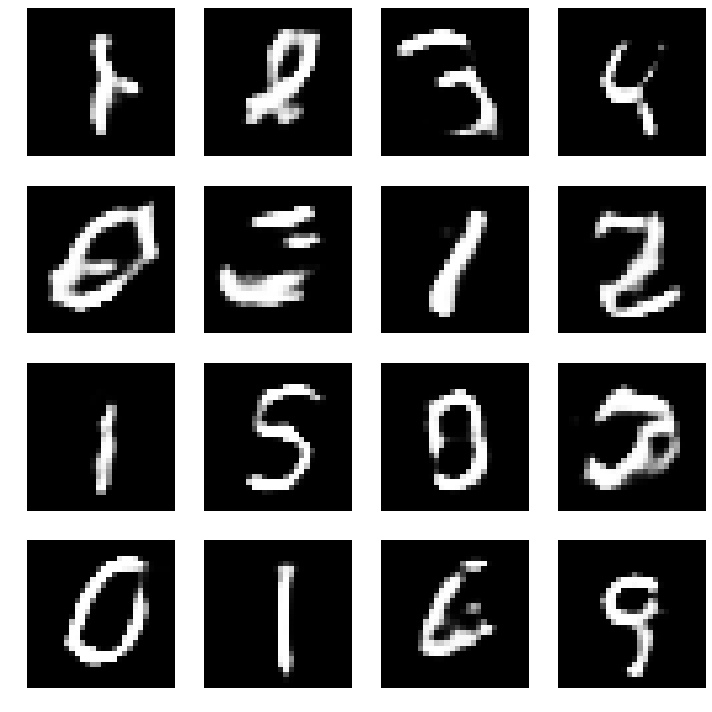

In [17]:
# Generate batch of synthetic MNIST images
timer.elapsed_time()
mnist_dcgan.plot_images(fake=True)
mnist_dcgan.plot_images(fake=False, save2file=True)